# Temporal (3 Chunk) Analysis of Chat Level Features 

In [1]:
from features.positivity_zscore import *
from features.lexical_features_v2 import *
from utils.summarize_chat_level_features import *
from utils.assign_chunk_nums import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [23]:
def preprocess_conversation_columns(df):
	# remove all special characters from df
	df.columns = df.columns.str.replace('[^A-Za-z0-9_]', '', regex=True)
	
	# If data is grouped by batch/round, add a conversation num
	if {'batch_num', 'round_num'}.issubset(df.columns):
		df['conversation_num'] = df.groupby(['batch_num', 'round_num']).ngroup()
		df = df[df.columns.tolist()[-1:] + df.columns.tolist()[0:-1]] # make the new column first

	return(df)

def get_average(chat_level_data, column_to_summarize, new_column_name):
	grouped_conversation_data = get_count_dataframe(chat_level_data, column_to_summarize)
	grouped_conversation_data[new_column_name] = grouped_conversation_data.groupby([["conversation_num", "chunk_num"]], sort=False)[column_to_summarize].transform(lambda x: np.mean(x))
	return(grouped_conversation_data[["conversation_num", "chunk_num", new_column_name]].drop_duplicates())

def get_count_dataframe(chat_level_data, on_column, speaker_id = "speaker_nickname"):
	grouped_conversation_data = chat_level_data[["conversation_num", "chunk_num", speaker_id, on_column]].groupby(["conversation_num", speaker_id]).sum().reset_index() 
    # gets this dataframe:
	# Batch# Round# Speaker  Total Number of Words
	# 0 	 1      Priya    100
	# 0      1      Yuluan   90
	return(grouped_conversation_data)

def plot_dd_results(dd_results, category):
	for col in dd_results:
		if (col != 'conversation_num') & (col !='chunk_num') & (col == category):
			plt.figure(figsize=(12, 6))
			for conversation_num, group in dd_results.groupby('conversation_num'):
				plt.plot(group['chunk_num_plt'], group[col], label=f'Conversation {conversation_num}')

			plt.xlabel('Chunk Number (Each contains third of chats)')
			plt.ylabel(col)
			plt.title(col + ' over time')
			print(col)
			plt.show()
    

In [13]:
df = pd.read_csv('data/raw_data/jury_conversations_with_outcome_var.csv')
df = preprocess_conversation_columns(df)
df = df.dropna()

In [15]:
liwc = liwc_features(df)
appended = assign_chunk_nums(pd.concat([df['conversation_num'], liwc], axis = 1), 3)
liwc_chunk_avg = appended.groupby(['conversation_num', 'chunk_num']).apply(lambda x: x.mean())
liwc_chunk_avg

conversation_num  discrepancies      hear   
conversation_num chunk_num                                              
0                0                       0.0       0.388889  0.000000  \
                 1                       0.0       0.500000  0.111111   
                 2                       0.0       0.250000  0.000000   
1                0                       1.0       0.400000  0.133333   
                 1                       1.0       0.733333  0.200000   
...                                      ...            ...       ...   
346              1                     346.0       0.555556  0.000000   
                 2                     346.0       0.166667  0.000000   
347              0                     347.0       0.090909  0.045455   
                 1                     347.0       0.318182  0.000000   
                 2                     347.0       0.150000  0.000000   

                                home  conjunction  certainty  inclusive   
conversation_num chunk_num                                                
0                0          0.055556     0.833333   0.111111   0.166667  \
                 1          0.111111     1.611111   0.166667   0.611111   
                 2          0.125000     1.000000   0.312500   0.562500   
1                0          0.133333     0.933333   0.200000   0.266667   
                 1          0.066667     0.800000   0.200000   0.400000   
...                              ...          ...        ...        ...   
346              1          0.111111     0.500000   0.111111   0.388889   
                 2          0.055556     0.500000   0.111111   0.277778   
347              0          0.090909     0.545455   0.045455   0.181818   
                 1          0.000000     0.636364   0.136364   0.727273   
                 2          0.050000     0.400000   0.050000   0.300000   

                                 bio  achievement   adverbs  ...   
conversation_num chunk_num                                   ...   
0                0          0.055556     0.222222  0.722222  ...  \
                 1          0.166667     0.555556  0.722222  ...   
                 2          0.000000     0.125000  0.687500  ...   
1                0          0.000000     0.133333  0.933333  ...   
                 1          0.000000     0.133333  0.600000  ...   
...                              ...          ...       ...  ...   
346              1          0.000000     0.055556  0.666667  ...   
                 2          0.000000     0.055556  0.444444  ...   
347              0          0.000000     0.090909  0.409091  ...   
                 1          0.000000     0.272727  0.181818  ...   
                 2          0.050000     0.250000  0.500000  ...   

                            cognitive_mech  preposition  first_person_plural   
conversation_num chunk_num                                                     
0                0                3.277778     1.777778             0.000000  \
                 1                4.888889     2.555556             0.055556   
                 2                2.625000     1.250000             0.062500   
1                0                2.533333     1.333333             0.000000   
                 1                2.533333     1.733333             0.000000   
...                                    ...          ...                  ...   
346              1                1.833333     1.111111             0.055556   
                 2                1.444444     0.444444             0.000000   
347              0                1.318182     1.181818             0.000000   
                 1                2.409091     1.636364             0.045455   
                 2                1.900000     1.150000             0.050000   

                             percept  second_person  positive_words   
conversation_num chunk_num                                            
0                0          0.2777

In [18]:
liwc_chunk_avg = liwc_chunk_avg.reset_index(drop=True)
liwc_chunk_avg['chunk_num_plt'] = liwc_chunk_avg.groupby('conversation_num').cumcount() + 1
liwc_chunk_avg

,conversation_num,discrepancies,hear,home,conjunction,certainty,inclusive,bio,achievement,adverbs,...,preposition,first_person_plural,percept,second_person,positive_words,first_person,nltk_english_stopwords,hedge_words,chunk_num,chunk_num_plt
0,0.0,0.388889,0.000000,0.055556,0.833333,0.111111,0.166667,0.055556,0.222222,0.722222,...,1.777778,0.000000,0.277778,0.111111,0.444444,0.055556,7.111111,0.388889,0.000000e+00,1
1,0.0,0.500000,0.111111,0.111111,1.611111,0.166667,0.611111,0.166667,0.555556,0.722222,...,2.555556,0.055556,0.222222,0.111111,1.500000,0.055556,12.833333,0.333333,6.172840e+15,2
2,0.0,0.250000,0.000000,0.125000,1.000000,0.312500,0.562500,0.000000,0.125000,0.687500,...,1.250000,0.062500,0.000000,0.000000,0.437500,0.125000,6.062500,0.125000,1.388889e+14,3
3,1.0,0.400000,0.133333,0.133333,0.933333,0.200000,0.266667,0.000000,0.133333,0.933333,...,1.333333,0.000000,0.200000,0.000000,0.400000,0.000000,8.266667,0.133333,0.000000e+00,1
4,1.0,0.733333,0.200000,0.066667,0.800000,0.200000,0.400000,0.000000,0.133333,0.600000,...,1.733333,0.000000,0.333333,0.000000,0.533333,0.133333,8.200000,0.333333,7.407407e+12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,346.0,0.555556,0.000000,0.111111,0.500000,0.111111,0.388889,0.000000,0.055556,0.666667,...,1.111111,0.055556,0.000000,0.111111,0.611111,0.166667,5.388889,0.111111,6.172840e+15,2
1040,346.0,0.166667,0.000000,0.055556,0.500000,0.111111,0.277778,0.000000,0.055556,0.444444,...,0.444444,0.000000,0.055556,0.277778,0.444444,0.277778,4.333333,0.055556,1.234568e+16,3
1041,347.0,0.090909,0.045455,0.090909,0.545455,0.045455,0.181818,0.000000,0.090909,0.409091,...,1.181818,0.000000,0.045455,0.090909,0.454545,0.136364,5.590909,0.045455,0.000000e+00,1
1042,347.0,0.318182,0.000000,0.000000,0.636364,0.136364,0.727273,0.000000,0.272727,0.181818,...,1.636364,0.045455,0.181818,0.000000,0.272727,0.181818,6.090909,0.000000,5.050505e+19,2


In [21]:
def max_chunks_screening(df, max_chunks):
    if (len(df) == max_chunks):
        return df

full_df = liwc_chunk_avg.groupby(['conversation_num']).apply(lambda x: max_chunks_screening(x, 3))
final = full_df.reset_index(drop=True)
final

,conversation_num,discrepancies,hear,home,conjunction,certainty,inclusive,bio,achievement,adverbs,...,preposition,first_person_plural,percept,second_person,positive_words,first_person,nltk_english_stopwords,hedge_words,chunk_num,chunk_num_plt
0,0.0,0.388889,0.000000,0.055556,0.833333,0.111111,0.166667,0.055556,0.222222,0.722222,...,1.777778,0.000000,0.277778,0.111111,0.444444,0.055556,7.111111,0.388889,0.000000e+00,1
1,0.0,0.500000,0.111111,0.111111,1.611111,0.166667,0.611111,0.166667,0.555556,0.722222,...,2.555556,0.055556,0.222222,0.111111,1.500000,0.055556,12.833333,0.333333,6.172840e+15,2
2,0.0,0.250000,0.000000,0.125000,1.000000,0.312500,0.562500,0.000000,0.125000,0.687500,...,1.250000,0.062500,0.000000,0.000000,0.437500,0.125000,6.062500,0.125000,1.388889e+14,3
3,1.0,0.400000,0.133333,0.133333,0.933333,0.200000,0.266667,0.000000,0.133333,0.933333,...,1.333333,0.000000,0.200000,0.000000,0.400000,0.000000,8.266667,0.133333,0.000000e+00,1
4,1.0,0.733333,0.200000,0.066667,0.800000,0.200000,0.400000,0.000000,0.133333,0.600000,...,1.733333,0.000000,0.333333,0.000000,0.533333,0.133333,8.200000,0.333333,7.407407e+12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,346.0,0.555556,0.000000,0.111111,0.500000,0.111111,0.388889,0.000000,0.055556,0.666667,...,1.111111,0.055556,0.000000,0.111111,0.611111,0.166667,5.388889,0.111111,6.172840e+15,2
1040,346.0,0.166667,0.000000,0.055556,0.500000,0.111111,0.277778,0.000000,0.055556,0.444444,...,0.444444,0.000000,0.055556,0.277778,0.444444,0.277778,4.333333,0.055556,1.234568e+16,3
1041,347.0,0.090909,0.045455,0.090909,0.545455,0.045455,0.181818,0.000000,0.090909,0.409091,...,1.181818,0.000000,0.045455,0.090909,0.454545,0.136364,5.590909,0.045455,0.000000e+00,1
1042,347.0,0.318182,0.000000,0.000000,0.636364,0.136364,0.727273,0.000000,0.272727,0.181818,...,1.636364,0.045455,0.181818,0.000000,0.272727,0.181818,6.090909,0.000000,5.050505e+19,2


positive_words


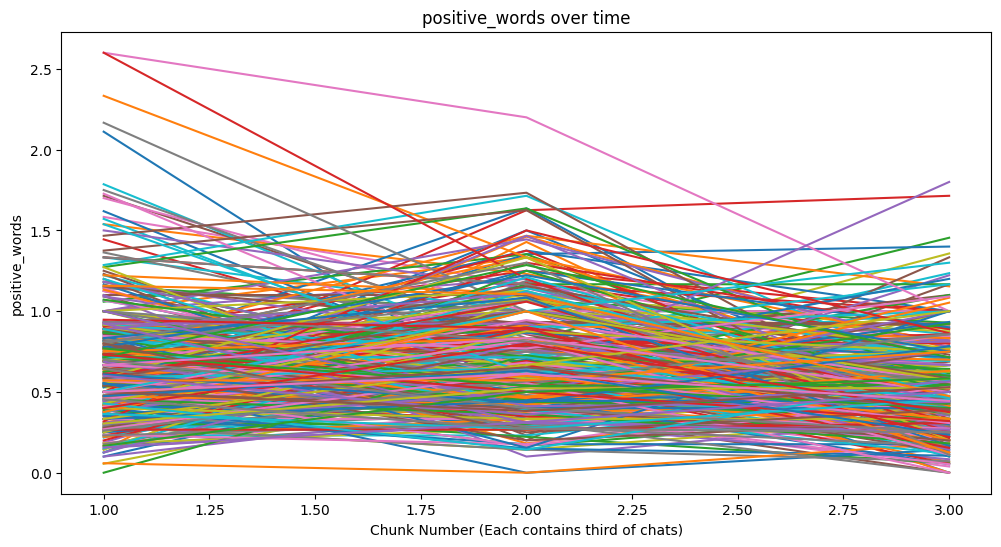

In [25]:
plot_dd_results(final, 'positive_words')

In [ ]:
final['positivity_zscore'] = final['positive_words'] - final['nltk_english_stopwords']